# Fully-connected neural network retrieval

This notebook implements a precipitation retrieval for the IPWG SPR dataset based on a convolutional neural network implemented using PyTorch and Lightning.

> **NOTE**: This notebook can be run on Google Colab. To install the necessary dependencies uncomment the following cell and execute it.

In [1]:
%load_ext autoreload
%autoreload 2
#!pip install git+https://github.com/simonpf/ipwgml#ipwgml[complete]

## The training data

The ``ipwgml`` package provides dataset classes that take care of downloading, preprocessing and loading of the SPR training data. The ``ipwgml.pytorch.dataset.SPRTabular`` class implements the PyTorch dataset interface for the SPR data in tabular format, i.e., for pixel-based retrievals.

The retrieval input data to load and the quality criteria for the reference surface precipitation data can be configured using the ``InputConfig`` classes from the ``ipwgml.input`` module and the ``TargetConfig`` class from the ``ipgml.target`` module, respectively.

For this example notebook we use only GMI observations as input. We configure the ``GMI`` input to not include the earth-incidence angles. Moreover, enable minimum-maximum normalization of the input and replace NAN values with -1.5.

> **NOTE**: Both input and reference data in the SPR dataset may contain NANs because observations or precipitation estimates may be missing or of insufficient quality. It is up to the user to handle those.

We choose the ``on_swath`` geometry for the retrieval, which is a natural choice for pixel-based retrievals. We also set up batching in the dataset, which is more efficient for tabular data than leaving it to the PyTorch data loader to perform the batching.

In [36]:
from ipwgml.input import GMI, Ancillary, Geo, GeoIR
from ipwgml.target import TargetConfig

target_config = TargetConfig(min_rqi=0.5)
inputs = [GeoIR(normalize="minmax", nan=-1.5)]
geometry = "gridded"
batch_size = 1024

In [34]:
from ipwgml.config import get_data_path
from ipwgml.data import get_local_files
files = get_local_files("spr", "gmi", "on_swath", "training")
get_data_path()
files

{'gmi': [PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/07/gmi_20180107211849.nc'),
  PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/09/gmi_20180109194023.nc'),
  PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/12/gmi_20180112033237.nc'),
  PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/17/gmi_20180117190250.nc'),
  PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/19/gmi_20180119234805.nc'),
  PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/23/gmi_20180123165400.nc'),
  PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/23/gmi_20180123165747.nc'),
  PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/24/gmi_20180124010436.nc'),
  PosixPath('/home/simon/data/ipwgml_spr_gmi/spr/gmi/training/xs/on_swath/2018/01/24/gmi_20180124023319.nc'),
  P

With these settings, we can instantiate the training data dataset. By setting ``stack=True`` we also tell the retrieval to stack all input tensors instead of loading the input data as a dictionary.

> **Note**: The current implementation of the dataset loads all training data into memory upon instantiation. Therefore, executing the cell below may take some time.

In [37]:
from torch.utils.data import DataLoader
from ipwgml.pytorch.datasets import SPRTabular

training_data = SPRTabular(
    reference_sensor="gmi",
    geometry=geometry,
    split="training",
    subset="s",
    retrieval_input=inputs,
    batch_size=batch_size,
    target_config=target_config,
    stack=True,
    download=True,
)
training_loader = DataLoader(training_data, shuffle=True, batch_size=None, num_workers=4)

<xarray.Dataset> Size: 8MB
Dimensions:       (samples: 63558, time: 16, latitude: 256, longitude: 256)
Coordinates:
  * latitude      (latitude) float64 2kB 41.74 41.71 41.67 ... 32.54 32.5 32.47
  * longitude     (longitude) float64 2kB -94.89 -94.86 -94.82 ... -85.65 -85.62
Dimensions without coordinates: samples, time
Data variables:
    observations  (samples, time) float64 8MB 275.0 275.0 276.0 ... 246.0 253.0


With the above configuration, the training data loaded by the ``training_loader`` has the following dimensions.

In [38]:
inpt, target = next(iter(training_loader))
print("Input tensor shape: ", inpt.shape)
print("Target tensor shape: ", target.shape)

Input tensor shape:  torch.Size([1024, 16])
Target tensor shape:  torch.Size([1024])


In [39]:
y = inpt[:, -1]
x = target

We also create a validation loader with the same configuration.

In [40]:
validation_data = SPRTabular(
    reference_sensor="gmi",
    geometry="on_swath",
    split="validation",
    subset="s",
    retrieval_input=inputs,
    batch_size=batch_size,
    target_config=target_config,
    stack=True,
    download=True,
    shuffle=False
)
validation_loader = DataLoader(validation_data, shuffle=True, batch_size=None)

<xarray.Dataset> Size: 104kB
Dimensions:       (samples: 804, time: 16, scan: 64, pixel: 64)
Coordinates:
  * scan          (scan) int64 512B 0 1 2 3 4 5 6 7 ... 56 57 58 59 60 61 62 63
  * pixel         (pixel) int64 512B 0 1 2 3 4 5 6 7 ... 56 57 58 59 60 61 62 63
Dimensions without coordinates: samples, time
Data variables:
    observations  (samples, time) float64 103kB nan 258.0 257.0 ... 274.0 274.0


In [41]:
from typing import Any, Callable, Dict

import torch
from torch import optim
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
import lightning as L

OUTPUTS = [
    "surface_precip",
    "probability_of_precip",
    "probability_of_heavy_precip"
]

N_EPOCHS = 20

class MLP(L.LightningModule):
    """
    Lightning module implementing a multi-layer perceptron (MLP) for retrieving precipitation from satellite
    observations.
    """
    def __init__(
        self,
        n_input_features: int,
        n_hidden_layers: int,
        n_neurons: int,
        activation_fn: Callable[[], nn.Module] = nn.GELU,
        normalization_layer: Callable[[int], nn.Module] = nn.LayerNorm,
        n_epochs: int = N_EPOCHS
    ):
        """
        Args:
            n_input_features: The number of features in the input
            n_hidden_layers: The number of hidden layers in the MLP
            n_neurons: The number of neurons in the hidden layers
            activation_fn: A callable to create activation function layers.
            normalization_layer: A callable to create normalization layers.
            n_epochs: The numebr of epochs the model will be trained for.
        """
        super().__init__()
        blocks = [
            nn.Linear(n_input_features, n_neurons),
            normalization_layer(n_neurons),
            activation_fn(),
        ]
        for _ in range(n_hidden_layers):
            blocks += [
                nn.Linear(n_neurons, n_neurons),
                normalization_layer(n_neurons),
                activation_fn(),
            ]
        self.body = nn.Sequential(*blocks)

        heads = {}
        for output in OUTPUTS:
            heads[output] =  nn.Sequential(
                nn.Linear(n_neurons, n_neurons),
                normalization_layer(n_neurons),
                activation_fn(),
                nn.Linear(n_neurons, 1)
            )
        self.heads = nn.ModuleDict(heads)
        self.n_epochs = N_EPOCHS

    def forward(self, retrieval_input: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Forward retrieval input through network and produce dictionary with predictions.

        Args:
            retrieval_input: The retrieval input as a single torch.Tensor.

        Return:
            A dictionary containing the predictions for 'surface_precip', 'probability_of_precip',
            and 'probability_of_heavy_precip'.
        """
        y = self.body(retrieval_input)
        return {
            name: module(y) for name, module in self.heads.items()
        }
        
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        """
        Calculates the loss-function gradients for the MLP.

        The loss is calculated as the sum of the MSE for 'surface_precip' and the binary cross-entropy loss
        for precipitation detection and heavy precipitation detection.

        Args:
            batch: A tuple containing the training data loaded from the data loader.
            batch_idx: The index of the batch in the current epoch. Not used.

        Return:
            A scalar torch.Tensor containing the total loss.
        """
        inpt, surface_precip = batch
        pred = self(inpt)

        valid = torch.isfinite(surface_precip)
        surface_precip = surface_precip[valid]
        precip_mask = (surface_precip > 1e-3).to(dtype=torch.float32)
        heavy_precip_mask = (surface_precip > 10).to(dtype=torch.float32)
        surface_precip_pred = pred["surface_precip"][valid]
        pop = pred["probability_of_precip"][valid]
        pohp = pred["probability_of_heavy_precip"][valid]
        
        # MSE loss for QPE
        loss_estim = ((surface_precip_pred[..., 0] - surface_precip) ** 2).mean()
        # BCE loss for detection targets
        loss_detect = binary_cross_entropy_with_logits(pop[..., 0], precip_mask)
        loss_detect_heavy = binary_cross_entropy_with_logits(pohp[..., 0], heavy_precip_mask)
        tot_loss =  loss_estim + loss_detect + loss_detect_heavy
        return tot_loss

    def validation_step(self, batch, batch_idx) -> None:
        """
        Calculates the loss-function values on validation data.

        Args:
            batch: A tuple containing the training data loaded from the data loader.
            batch_idx: The index of the batch in the current epoch. Not used.
        """
        inpt, surface_precip = batch
        pred = self(inpt)

        valid = torch.isfinite(surface_precip)
        surface_precip = surface_precip[valid]
        precip_mask = (surface_precip > 1e-3).to(dtype=torch.float32)
        heavy_precip_mask = (surface_precip > 10).to(dtype=torch.float32)
        surface_precip_pred = pred["surface_precip"][valid]
        pop = pred["probability_of_precip"][valid]
        pohp = pred["probability_of_heavy_precip"][valid]
        
        # MSE loss for QPE
        loss_estim = ((surface_precip_pred[..., 0] - surface_precip) ** 2).mean()
        # BCE loss for detection targets
        loss_detect = binary_cross_entropy_with_logits(pop[..., 0], precip_mask)
        loss_detect_heavy = binary_cross_entropy_with_logits(pohp[..., 0], heavy_precip_mask)
        tot_loss =  loss_estim + loss_detect + loss_detect_heavy

        opt = self.optimizers()
        learning_rate = opt.param_groups[0]['lr']
        
        self.log_dict(
            {
                "val_loss": loss_estim + loss_detect + loss_detect_heavy,
                "val_loss_estim": loss_estim,
                "val_loss_detect": loss_detect,
                "val_loss_detect_heavy": loss_detect_heavy,
                "learning_rate": learning_rate
            },
            on_epoch=True,
            prog_bar=True
        )
    
    def configure_optimizers(self) -> Dict[str, Any]:
        """
        We use the Adam optimizer with a cosine annealing learning rate schedule.
        """
        optimizer = optim.Adam(self.parameters(), lr=5e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler
        }

In [42]:
mlp = MLP(n_input_features=16, n_hidden_layers=8, n_neurons=256)

In [43]:
trainer = L.Trainer(max_epochs=N_EPOCHS)
trainer.fit(model=mlp, train_dataloaders=training_loader, val_dataloaders=validation_loader)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


[05/23/25 23:08:18] INFO     INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of  ]8;id=301252;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=95782;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             2 GPUs because it is running inside an interactive / notebook                         
                             environment. You may try to set `Trainer(devices=2)` but please note                  
                             that multi-GPU inside interactive / notebook environments is                          
                             considered experimental and unstable. Your mileage may vary.                          

INFO: GPU available: True (cuda), used: True


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), ]8;id=919734;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=42236;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             used: True                                                                            

INFO: TPU available: False, using: 0 TPU cores


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:TPU available: False,       ]8;id=305903;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=178907;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             using: 0 TPU cores                                                                    

INFO: HPU available: False, using: 0 HPUs


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:HPU available: False,       ]8;id=110501;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=240671;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             using: 0 HPUs                                                                         

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


                    INFO     INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 -                    ]8;id=275865;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=446117;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\
                             CUDA_VISIBLE_DEVICES: [0,1]                                                           

INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | body  | Sequential | 535 K  | train
1 | heads | ModuleDict | 199 K  | train
---------------------------------------------
734 K     Trainable params
0         Non-trainable params
734 K     Total params
2.940     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


                    INFO     INFO:lightning.pytorch.callbacks.model_summary:                   ]8;id=639397;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=290849;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_summary.py#104\104]8;;\
                               | Name  | Type       | Params | Mode                                                
                             ---------------------------------------------                                         
                             0 | body  | Sequential | 535 K  | train                                               
                             1 | heads | ModuleDict | 199 K  | train                                               
                             ---------------------------------------------                                         
                             734 K     Trainable params                                                            
                             0         Non-trainable params                                                        
                             734 K     Total params                                                                
                             2.940     Total estimated model params size (MB)                                      
                             44        Modules in train mode                                                       
                             0         Modules in eval mode                                                        

Sanity Checking: |                                                                                            …

/home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

Validation: |                                                                                                 …

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


[05/24/25 00:58:23] INFO     INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped:      ]8;id=566290;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=413725;file:///home/simon/miniforge3/envs/ipwgml/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             `max_epochs=20` reached.                                                              

# Evaluating the retrieval

In oder to compare the MLP-based precipitation retrieval to conventional precipitation retrievals, we can use the ``ipwgml.evaluation.Evaluator`` to evaluate the retrieval on the exact same overpasses that we used to evaluate [the IMERG](evaluate_imerg.ipynb) and [GPROF](evaluate_gprof.ipynb) retrievals. To ensure consistency between training and evaluation data, we instantiate the evaluator with the same values for ``geometry`` and ``retrieval_input``.

In [44]:
from ipwgml.evaluation import Evaluator
evaluator = Evaluator(
    reference_sensor="gmi",
    geometry=geometry,
    retrieval_input=inputs,
    domain="conus",
    download=True
)

## The retrieval callback function

Evaluating the MLP using the ``ipwgml.evaluation.Evaluator`` requires implementing a retrieval callback function that the evaluator can call to obtain the rerieval results for a given collocation scene. The ``Evaluator`` class supports loading the retrieval input data in tabular format. Therefore, all that has to be done ine retrieval callback function is extracting the required input data and feeding it into the MLP.

In [45]:
from ipwgml.pytorch import PytorchRetrieval
mlp_retrieval = PytorchRetrieval(mlp, retrieval_input=inputs, stack=True, device=torch.device("cpu"))

## Case study

/home/simon/data/ipwgml_spr_gmi/spr/gmi/evaluation/conus/gridded/2022/01/01/geo_ir_20220101022714.nc


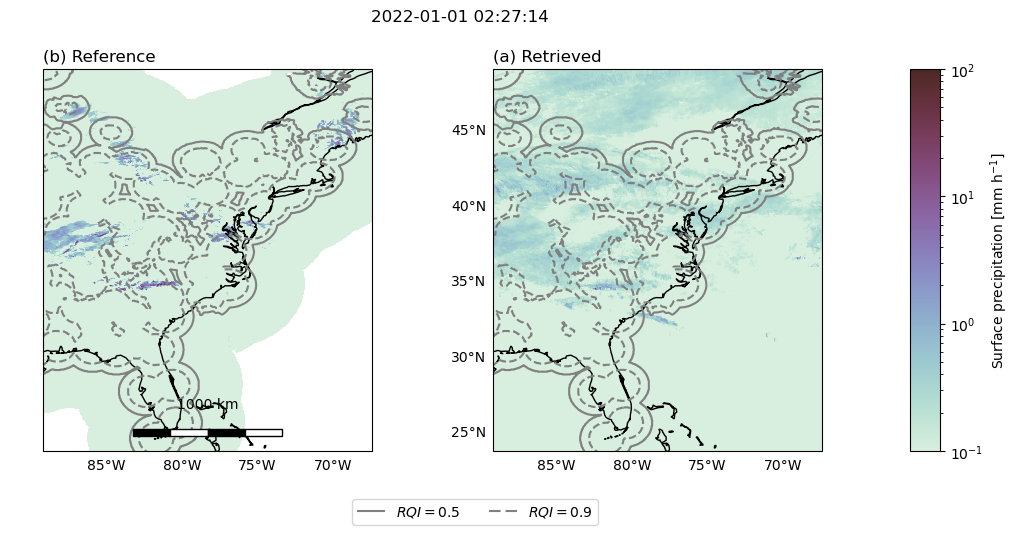

In [46]:
fig = evaluator.plot_retrieval_results(0, mlp_retrieval, input_data_format="tabular", batch_size=1024)

/home/simon/data/ipwgml_spr_gmi/spr/gmi/evaluation/conus/on_swath/2022/01/01/geo_ir_20220101022714.nc


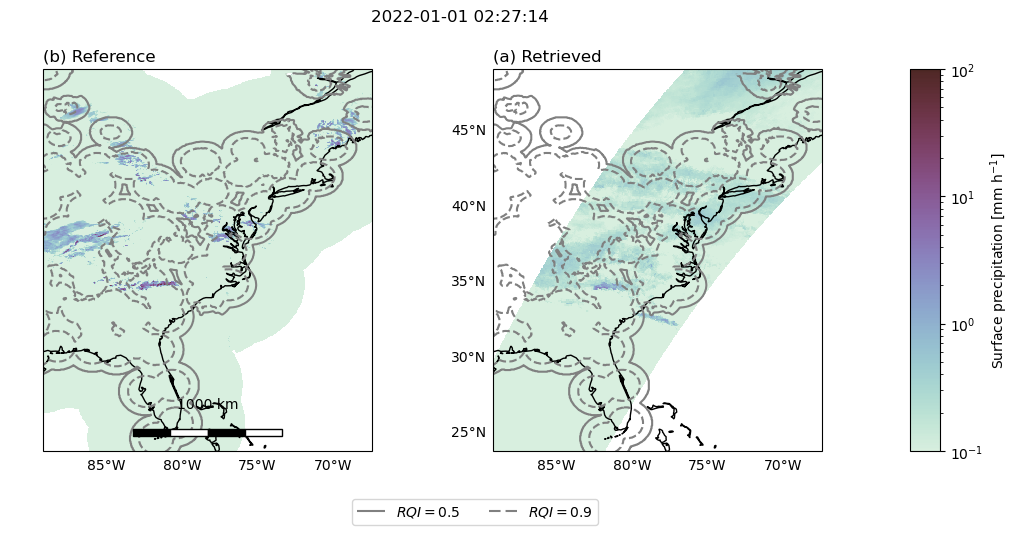

In [19]:
fig = evaluator.plot_retrieval_results(0, mlp_retrieval, input_data_format="tabular", batch_size=1024)

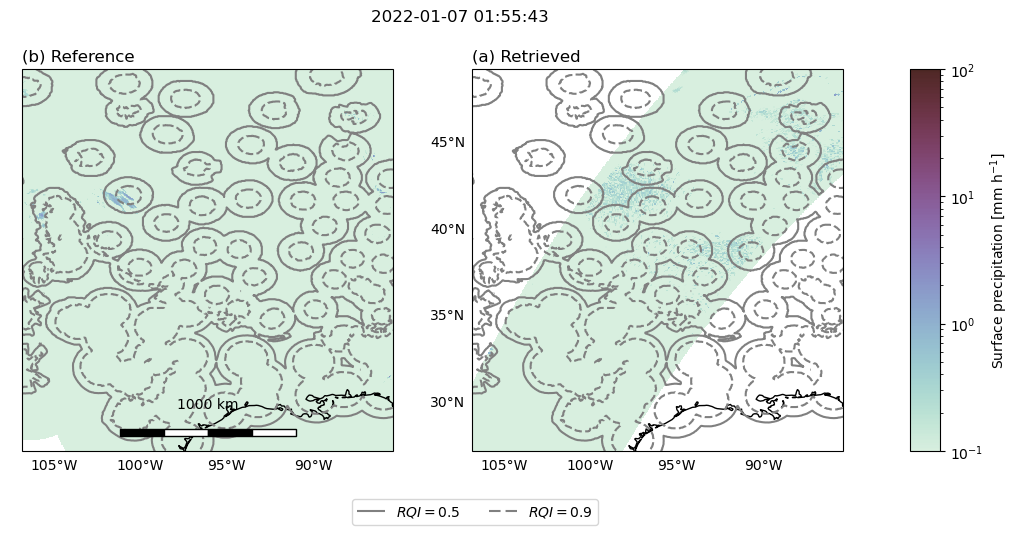

In [64]:
fig = evaluator.plot_retrieval_results(49, mlp_retrieval, input_data_format="tabular", batch_size=1024)

## Evaluation 

In [21]:
evaluator.evaluate(retrieval_fn=mlp_retrieval, input_data_format="tabular", batch_size=4048, n_processes=1)

Output()

## Results

### Precipitation quantification

In [22]:
evaluator.get_precip_quantification_results(name="MLP (GMI)").T

,MLP (GMI),IMERG Final V7 (GMI),GPROF V7 (GMI)
Bias [$\%$],-8.161608,-7.398772,5.799770
MAE [$mm h^{-1}$],0.101430,0.124924,0.119785
MSE [$(mm h^{-1})^2$],0.843856,1.731411,1.413339
SMAPE$_{0.1}$ [$\%$],84.773240,114.417614,91.327371
Correlation coeff. [],0.661201,0.455411,0.552348
Effective resolution [$^\circ$],inf,inf,0.423000


In [28]:
res = evaluator.precip_quantification_metrics[-1].compute()

In [30]:
res.spectral_coherence

<xarray.DataArray 'spectral_coherence' (scales: 24)> Size: 192B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * scales   (scales) float64 192B inf 0.846 0.423 ... 0.04029 0.03845 0.03678
Attributes:
    full_name:  Spectral coherence
    unit:

In [48]:
sc = evaluator.precip_quantification_metrics[-1].compute()

/home/simon/src/ipwgml/src/ipwgml/metrics.py:665: RuntimeWarning: divide by zero encountered in divide
  scales = 0.5 * (N - 1) * self.scale / n


### Precipitation detection

In [50]:
evaluator.get_precip_detection_results(name="MLP (GMI)").T

,MLP (GMI),IMERG Final V7 (GMI),GPROF V7 (GMI)
POD [],0.677825,0.687576,0.758366
FAR [],0.239219,0.497714,0.462010
HSS [],0.750935,0.470956,0.508161


### Probabilistic precipitation detection

In [51]:
evaluator.get_prob_precip_detection_results(name="MLP (GMI)").T

/home/simon/src/ipwgml/src/ipwgml/metrics.py:904: RuntimeWarning: invalid value encountered in divide
  precision = self.n_tp / (self.n_tp + self.n_fp)


,MLP (GMI),IMERG Final V7 (GMI),GPROF V7 (GMI)
AUC [],0.763957,0.0,0.54994


### Heavy precipitation detection

In [52]:
evaluator.get_heavy_precip_detection_results(name="MLP (GMI)").T

,MLP (GMI),IMERG Final V7 (GMI),GPROF V7 (GMI)
POD [],0.354196,0.687576,0.758366
FAR [],0.381846,0.497714,0.462010
HSS [],0.617587,0.470956,0.508161


### Heavy probabilistic precipitation detection

In [53]:
evaluator.get_prob_heavy_precip_detection_results(name="MLP (GMI)").T

/home/simon/src/ipwgml/src/ipwgml/metrics.py:904: RuntimeWarning: invalid value encountered in divide
  precision = self.n_tp / (self.n_tp + self.n_fp)


,MLP (GMI),IMERG Final V7 (GMI),GPROF V7 (GMI)
AUC [],0.488586,0.0,0.298044
